In [ ]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [ ]:
# Dados
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)


In [ ]:
def eval_classification(y_true, y_pred, name="Modelo"):
    print(f"\n=== {name} ===")
    print("Accuracy:",  accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='macro'))
    print("Recall:",    recall_score(y_true, y_pred, average='macro'))
    print("F1:",        f1_score(y_true, y_pred, average='macro'))
    print("MSE:",       mean_squared_error(y_true, y_pred))


In [ ]:
def get_oof_preds(clf, X_train, y_train, X_test, n_splits=5, name="model"):
    """
    Gera:
    - oof_pred_proba: previsões out-of-fold (treino)
    - test_pred_proba_mean: média das previsões no teste ao longo dos folds
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    n_classes = len(np.unique(y_train))
    oof_pred_proba = np.zeros((X_train.shape[0], n_classes))
    test_pred_proba = np.zeros((X_test.shape[0], n_classes, n_splits))
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[valid_idx]
        y_tr, y_val = y_train[train_idx], y_train[valid_idx]
        
        model = clf  # instância nova por fold se necessário
        model.fit(X_tr, y_tr)
        
        oof_pred_proba[valid_idx] = model.predict_proba(X_val)
        test_pred_proba[:, :, fold] = model.predict_proba(X_test)
    
    test_pred_proba_mean = test_pred_proba.mean(axis=2)
    
    print(f"OOF gerado para {name}")
    return oof_pred_proba, test_pred_proba_mean


In [ ]:
base_models_level1 = {
    "xgb": XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=3,
        subsample=0.8, colsample_bytree=0.8,
        objective="multi:softprob", eval_metric="mlogloss",
        num_class=len(np.unique(y_train)), random_state=42
    ),
    "lgbm": LGBMClassifier(
        n_estimators=200, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42
    ),
    "cat": CatBoostClassifier(
        iterations=200, learning_rate=0.1, depth=4,
        loss_function='MultiClass', verbose=False,
        random_state=42
    ),
    "rf": RandomForestClassifier(
        n_estimators=200, max_depth=None,
        random_state=42
    ),
    "svm": SVC(
        probability=True, kernel='rbf', C=1.0, gamma='scale',
        random_state=42
    ),
    "logreg": LogisticRegression(
        max_iter=1000
    ),
    "tree": DecisionTreeClassifier(
        max_depth=4, random_state=42
    )
}


In [ ]:
oof_level1_list = []
test_level1_list = []

for name, model in base_models_level1.items():
    oof_pred, test_pred = get_oof_preds(
        clf=model,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        n_splits=5,
        name=name
    )
    oof_level1_list.append(oof_pred)
    test_level1_list.append(test_pred)

# Concatenar previsões de todos os modelos
X_train_level2 = np.hstack(oof_level1_list)
X_test_level2  = np.hstack(test_level1_list)

print("Shape camada 1 -> camada 2:")
print(X_train_level2.shape, X_test_level2.shape)


In [ ]:
models_level2 = {
    "xgb_l2": XGBClassifier(
        n_estimators=150, learning_rate=0.1, max_depth=3,
        subsample=0.8, colsample_bytree=0.8,
        objective="multi:softprob", eval_metric="mlogloss",
        num_class=len(np.unique(y_train)), random_state=42
    ),
    "lgbm_l2": LGBMClassifier(
        n_estimators=150, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42
    ),
    "cat_l2": CatBoostClassifier(
        iterations=150, learning_rate=0.1, depth=4,
        loss_function='MultiClass', verbose=False,
        random_state=42
    ),
    "logreg_l2": LogisticRegression(
        max_iter=1000
    )
}


In [ ]:
oof_level2_list = []
test_level2_list = []

for name, model in models_level2.items():
    oof_pred, test_pred = get_oof_preds(
        clf=model,
        X_train=X_train_level2,
        y_train=y_train,
        X_test=X_test_level2,
        n_splits=5,
        name=name
    )
    oof_level2_list.append(oof_pred)
    test_level2_list.append(test_pred)

X_train_level3 = np.hstack(oof_level2_list)
X_test_level3  = np.hstack(test_level2_list)

print("Shape camada 2 -> camada 3:")
print(X_train_level3.shape, X_test_level3.shape)


In [ ]:
meta_model = LogisticRegression(max_iter=2000)

meta_model.fit(X_train_level3, y_train)
y_pred_final = meta_model.predict(X_test_level3)

eval_classification(y_test, y_pred_final, "Stacking Manual 3 Camadas (Final)")


In [ ]:
baseline = XGBClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=3,
    subsample=0.8, colsample_bytree=0.8,
    objective="multi:softprob", eval_metric="mlogloss",
    num_class=len(np.unique(y_train)), random_state=42
)

baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

eval_classification(y_test, y_pred_base, "Baseline (XGB sozinho)")


OOF gerado para xgb
[LightGBM] [Info] Number of positive: 191, number of negative: 307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 164
[LightGBM] [Info] Number of data points in the train set: 498, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383534 -> initscore=-0.474574
[LightGBM] [Info] Start training from score -0.474574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMCla

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


OOF gerado para cat
OOF gerado para rf
OOF gerado para svm
OOF gerado para logreg
OOF gerado para tree
OOF gerado para xgb_l2
[LightGBM] [Info] Number of positive: 191, number of negative: 307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1946
[LightGBM] [Info] Number of data points in the train set: 498, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383534 -> initscore=-0.474574
[LightGBM] [Info] Start training from score -0.474574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMCla

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tailan/Imagens/Auxi/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


OOF gerado para cat_l2
OOF gerado para logreg_l2

=== Stacking Manual 3 Camadas (Final) ===
Accuracy: 0.8395522388059702
Precision: 0.8947368421052632
Recall: 0.6601941747572816
F1: 0.7597765363128491
MSE: 0.16044776119402984

=== Baseline (XGB sozinho) ===
Accuracy: 0.8059701492537313
Precision: 0.8072289156626506
Recall: 0.6504854368932039
F1: 0.7204301075268817
MSE: 0.19402985074626866


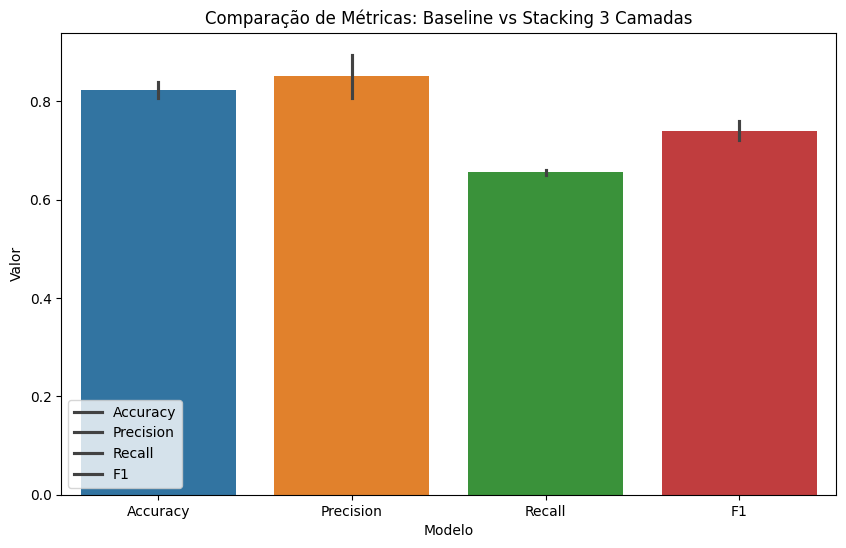

<Figure size 500x500 with 0 Axes>

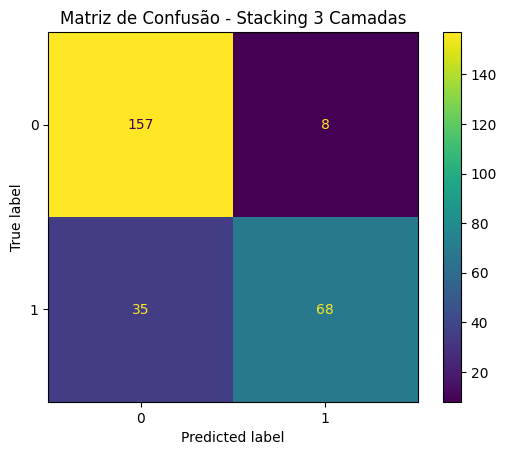

<Figure size 600x500 with 0 Axes>

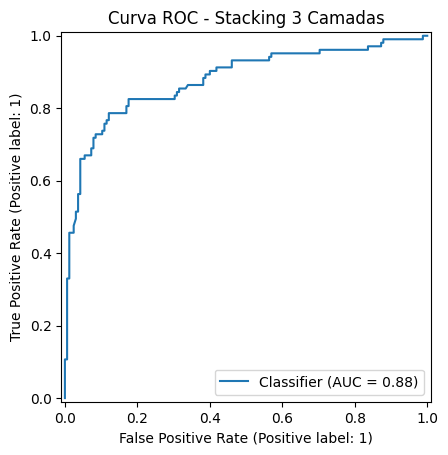

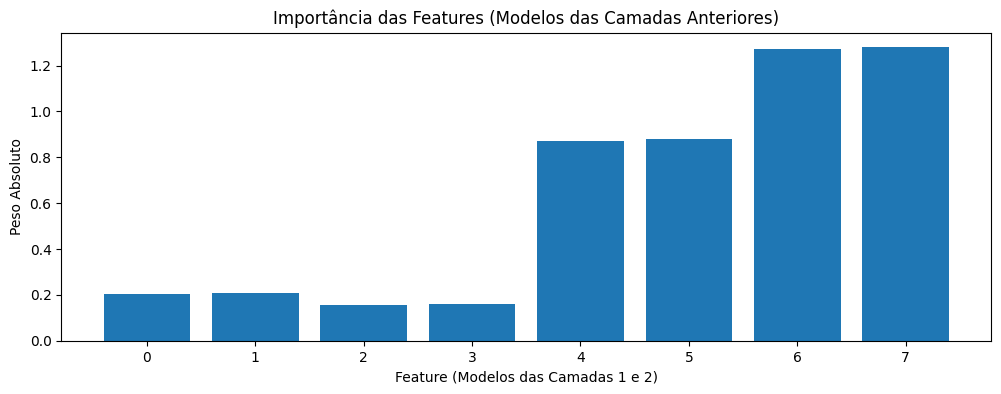

In [1]:
# ============================================================
# 1. Instalação de bibliotecas necessárias
# ============================================================
!pip install xgboost lightgbm catboost seaborn -q

# ============================================================
# 2. Imports
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, mean_squared_error, ConfusionMatrixDisplay, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ============================================================
# 3. Carregar dataset Titanic
# ============================================================
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

df = df[['Survived','Pclass','Sex','Age','Fare','Embarked']]
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

X = df.drop('Survived', axis=1)
y = df['Survived']

# ============================================================
# 4. Pré-processamento
# ============================================================
numeric_cols = ['Age','Fare','Pclass']
categorical_cols = ['Sex','Embarked']

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

X_processed = preprocess.fit_transform(X)

# ============================================================
# 5. Divisão treino/teste
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42, stratify=y
)

# ============================================================
# 6. Função de métricas
# ============================================================
def eval_classification(y_true, y_pred, name="Modelo"):
    print(f"\n=== {name} ===")
    print("Accuracy:",  accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:",    recall_score(y_true, y_pred))
    print("F1:",        f1_score(y_true, y_pred))
    print("MSE:",       mean_squared_error(y_true, y_pred))

# ============================================================
# 7. Função para gerar OOF
# ============================================================
def get_oof_preds(clf, X_train, y_train, X_test, n_splits=5, name="model"):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    oof_pred = np.zeros((X_train.shape[0], 2))
    test_pred = np.zeros((X_test.shape[0], 2, n_splits))
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = clf
        model.fit(X_tr, y_tr)
        
        oof_pred[valid_idx] = model.predict_proba(X_val)
        test_pred[:,:,fold] = model.predict_proba(X_test)
    
    print(f"OOF gerado para {name}")
    return oof_pred, test_pred.mean(axis=2)

# ============================================================
# 8. Camada 1 — modelos base
# ============================================================
base_models_level1 = {
    "xgb": XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=3,
        subsample=0.8, colsample_bytree=0.8,
        objective="binary:logistic", eval_metric="logloss",
        random_state=42
    ),
    "lgbm": LGBMClassifier(
        n_estimators=200, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42
    ),
    "cat": CatBoostClassifier(
        iterations=200, learning_rate=0.1, depth=4,
        loss_function='Logloss', verbose=False,
        random_state=42
    ),
    "rf": RandomForestClassifier(
        n_estimators=200, random_state=42
    ),
    "svm": SVC(
        probability=True, kernel='rbf', C=1.0, gamma='scale',
        random_state=42
    ),
    "logreg": LogisticRegression(max_iter=1000),
    "tree": DecisionTreeClassifier(max_depth=4, random_state=42)
}

# ============================================================
# 9. Gerar OOF da camada 1
# ============================================================
oof_level1 = []
test_level1 = []

for name, model in base_models_level1.items():
    oof_pred, test_pred = get_oof_preds(
        model, X_train, y_train, X_test, name=name
    )
    oof_level1.append(oof_pred)
    test_level1.append(test_pred)

X_train_level2 = np.hstack(oof_level1)
X_test_level2  = np.hstack(test_level1)

# ============================================================
# 10. Camada 2 — novos modelos
# ============================================================
models_level2 = {
    "xgb_l2": XGBClassifier(
        n_estimators=150, learning_rate=0.1, max_depth=3,
        subsample=0.8, colsample_bytree=0.8,
        objective="binary:logistic", eval_metric="logloss",
        random_state=42
    ),
    "lgbm_l2": LGBMClassifier(
        n_estimators=150, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42
    ),
    "cat_l2": CatBoostClassifier(
        iterations=150, learning_rate=0.1, depth=4,
        loss_function='Logloss', verbose=False,
        random_state=42
    ),
    "logreg_l2": LogisticRegression(max_iter=1000)
}

# ============================================================
# 11. Gerar OOF da camada 2
# ============================================================
oof_level2 = []
test_level2 = []

for name, model in models_level2.items():
    oof_pred, test_pred = get_oof_preds(
        model, X_train_level2, y_train, X_test_level2, name=name
    )
    oof_level2.append(oof_pred)
    test_level2.append(test_pred)

X_train_level3 = np.hstack(oof_level2)
X_test_level3  = np.hstack(test_level2)

# ============================================================
# 12. Camada 3 — meta-modelo final
# ============================================================
meta_model = LogisticRegression(max_iter=2000)
meta_model.fit(X_train_level3, y_train)
y_pred_final = meta_model.predict(X_test_level3)

eval_classification(y_test, y_pred_final, "Stacking Manual 3 Camadas (Final)")

# ============================================================
# 13. Baseline para comparação
# ============================================================
baseline = XGBClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=3,
    subsample=0.8, colsample_bytree=0.8,
    objective="binary:logistic", eval_metric="logloss",
    random_state=42
)

baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

eval_classification(y_test, y_pred_base, "Baseline (XGB sozinho)")

# ============================================================
# 14. Comparação gráfica
# ============================================================
results = {
    "Baseline_XGB": {
        "Accuracy": accuracy_score(y_test, y_pred_base),
        "Precision": precision_score(y_test, y_pred_base),
        "Recall": recall_score(y_test, y_pred_base),
        "F1": f1_score(y_test, y_pred_base)
    },
    "Stacking_3_Camadas": {
        "Accuracy": accuracy_score(y_test, y_pred_final),
        "Precision": precision_score(y_test, y_pred_final),
        "Recall": recall_score(y_test, y_pred_final),
        "F1": f1_score(y_test, y_pred_final)
    }
}

df_results = pd.DataFrame(results).T

plt.figure(figsize=(10,6))
sns.barplot(data=df_results)
plt.title("Comparação de Métricas: Baseline vs Stacking 3 Camadas")
plt.ylabel("Valor")
plt.xlabel("Modelo")
plt.legend(df_results.columns)
plt.show()

# ============================================================
# 15. Matriz de confusão
# ============================================================
plt.figure(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final)
plt.title("Matriz de Confusão - Stacking 3 Camadas")
plt.show()

# ============================================================
# 16. Curva ROC
# ============================================================
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(
    y_test, meta_model.predict_proba(X_test_level3)[:,1]
)
plt.title("Curva ROC - Stacking 3 Camadas")
plt.show()

# ============================================================
# 17. Importância dos modelos (camadas anteriores)
# ============================================================
importances = np.abs(meta_model.coef_).flatten()

plt.figure(figsize=(12,4))
plt.bar(range(len(importances)), importances)
plt.title("Importância das Features (Modelos das Camadas Anteriores)")
plt.xlabel("Feature (Modelos das Camadas 1 e 2)")
plt.ylabel("Peso Absoluto")
plt.show()
